In [1]:
%pip install datasets matplotlib numpy scikit-learn sentence_transformers wordcloud -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import random
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import gc
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, classification_report, accuracy_score
import pandas as pd

ds = load_dataset("PleIAs/French-PD-Books")

/home/matheo/.conda/envs/projet_ia5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


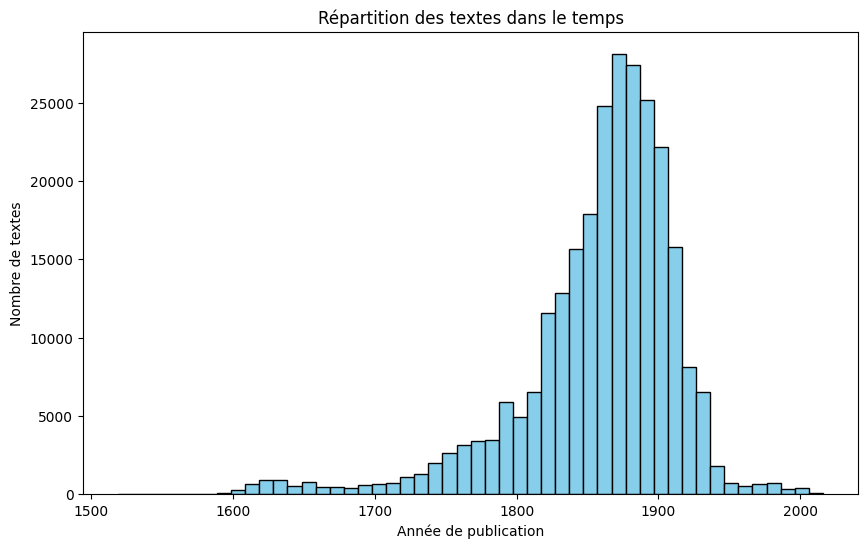

In [3]:
# Extraire les années de publication
years = ds['train']['date']

# Nettoyer et convertir en entiers (certaines dates peuvent être manquantes ou non numériques)
years_clean = [int(y) for y in years if str(y).isdigit()]

# Créer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(years_clean, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Année de publication')
plt.ylabel('Nombre de textes')
plt.title('Répartition des textes dans le temps')
plt.show()

In [4]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['file_id', 'ocr', 'title', 'date', 'author', 'page_count', 'word_count', 'character_count', 'complete_text'],
        num_rows: 289577
    })
})


In [5]:
french_stopwords = set([
    'a', 'ai', 'aie', 'aient', 'aies', 'ait', 'alors', 'as', 'au', 'aucun', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'autre', 'aux', 'avaient', 'avais', 'avait', 'avant', 'avec', 'avez', 'aviez', 'avions', 'avoir', 'avons', 'ayant', 'ayez', 'ayons',
    'bon',
    'c', 'ce', 'ceci', 'cela', 'ces', 'cet', 'cette', 'chaque', 'comme', 'comment',
    'd', 'dans', 'de', 'des', 'deux', 'donc', 'dont', 'du',
    'elle', 'en', 'encore', 'es', 'est', 'et', 'etaient', 'etais', 'etait', 'etant', 'ete', 'etes', 'etiez', 'etions', 'etre', 'eu', 'eue', 'eues', 'eurent', 'eus', 'eusse', 'eussent', 'eusses', 'eussiez', 'eussions', 'eut', 'eux', 'eûmes', 'eût', 'eûtes',
    'fait', 'fais', 'faisaient', 'faisais', 'faisait', 'faisant', 'faire', 'faites', 'fasse', 'fassent', 'fasses', 'fassiez', 'fassions', 'faut', 'fi', 'font', 'force', 'furent', 'fus', 'fusse', 'fussent', 'fusses', 'fussiez', 'fussions', 'fut', 'fûmes', 'fût', 'fûtes',
    'hors',
    'i', 'ici', 'il', 'ils',
    'j', 'je',
    'l', 'la', 'le', 'les', 'leur', 'leurs', 'lui',
    'm', 'ma', 'mais', 'me', 'mes', 'moi', 'mon',
    'n', 'ne', 'ni', 'nos', 'notre', 'nous',
    'on', 'ont', 'ou', 'où',
    'par', 'pas', 'pendant', 'peu', 'peut', 'peux', 'plus', 'point', 'pour', 'pourquoi',
    'qu', 'quand', 'que', 'quel', 'quelle', 'quelles', 'quels', 'qui',
    's', 'sa', 'sans', 'se', 'sera', 'serai', 'seraient', 'serais', 'serait', 'seras', 'serez', 'seriez', 'serions', 'serons', 'seront', 'ses', 'soi', 'soient', 'sois', 'soit', 'sommes', 'son', 'sont', 'soyez', 'soyons', 'suis', 'sur',
    't', 'ta', 'te', 'tes', 'toi', 'ton', 'tous', 'tout', 'tu', 'un', 'une',
    'va', 'vers', 'voici', 'voilà', 'vos', 'votre', 'vous',
    'y', 'à'
])

In [6]:
# Ancienne version
def clean_text_old(example):
    text = example["complete_text"]
    date = example.get("date", None)

    # Si la date contient un "-", on essaie d'extraire l'année connue (format "1234-????" ou "????-1234") ou moyenne des deux années
    if "-" in str(date) and date is not None:
        parts = str(date).split("-")
        if (parts[1].isdigit() and len(parts[1]) == 4) and parts[0] == "????":
            date = str(parts[1])
        else:
            date = str(parts[0])

    # 1. Retirer les numéros de page
    text = re.sub(r"[—\-–]\s*\d+\s*[—\-–]", " ", text)
    
    # 2. Corriger les apostrophes et guillemets échappés
    text = text.replace("\\'", "'")
    text = text.replace("\\\"", "\"")
    text = text.replace("\\n", " ")
    text = text.replace("\\r", " ")
    text = text.replace("\\t", " ")
    
    # 3. Corriger les mots coupés (pattern plus précis)
    text = re.sub(r'([a-zàâäæçéèêëïîôùûüœ])\s+([a-zàâäæçéèêëïîôùûüœ]{2,})', 
                  r'\1\2', text)
    
    # 4. Corriger les cas avec plusieurs espaces
    text = re.sub(r'([a-zàâäæçéèêëïîôùûüœ])\s{2,}([a-zàâäæçéèêëïîôùûüœ])', 
                  r'\1\2', text)
    
    # 5. Normaliser les espaces multiples
    text = re.sub(r"\s+", " ", text)
    
    # 6. Nettoyer les caractères spéciaux
    text = re.sub(r"[^\w\s\.,;:\?!'\-\"«»À-ÖØ-öø-ÿœŒ]", " ", text)
    
    # 7. Re-normaliser après nettoyage
    text = re.sub(r"\s+", " ", text)
    
    # 8. Corriger la ponctuation
    text = re.sub(r"\s+([,.\?!;:])", r"\1", text)
    text = re.sub(r"([,.\?!;:])\s*([,.\?!;:])", r"\1\2", text)
    
    text = text.strip()
    return {"text": text, "date": str(date)}

In [7]:
def clean_text(example):
    """
        Nettoie le texte d'entrée
    """
    text = example["complete_text"]
    date = example.get("date", None)

    # --- Nettoyage de la date
    if "-" in str(date) and date is not None:
        parts = str(date).split("-")
        if (parts[1].isdigit() and len(parts[1]) == 4) and parts[0] == "????":
            date = str(parts[1])
        else:
            date = str(parts[0])

    # --- Nettoyage de texte
    text = (text.replace("\\n", " ")
                .replace("\\r", " ")
                .replace("\\t", " "))
    
    text = text.lower()

    text = re.sub(r"[^a-zàâäæçéèêëïîôùûüœ\s]", " ", text)
    
    text = re.sub(r"\s+", " ", text).strip()

    words = text.split()
    filtered_words = [word for word in words if word not in french_stopwords]
    text = " ".join(filtered_words)

    return {"text": text, "date": str(date)}

In [8]:
reduced_ds = ds['train'].shuffle(seed=42).select(range(5000))

cleaned_ds = reduced_ds.map(clean_text, remove_columns=reduced_ds.column_names)
# cleaned_ds = ds['train'].map(clean_text, remove_columns=ds['train'].column_names, num_proc=4)

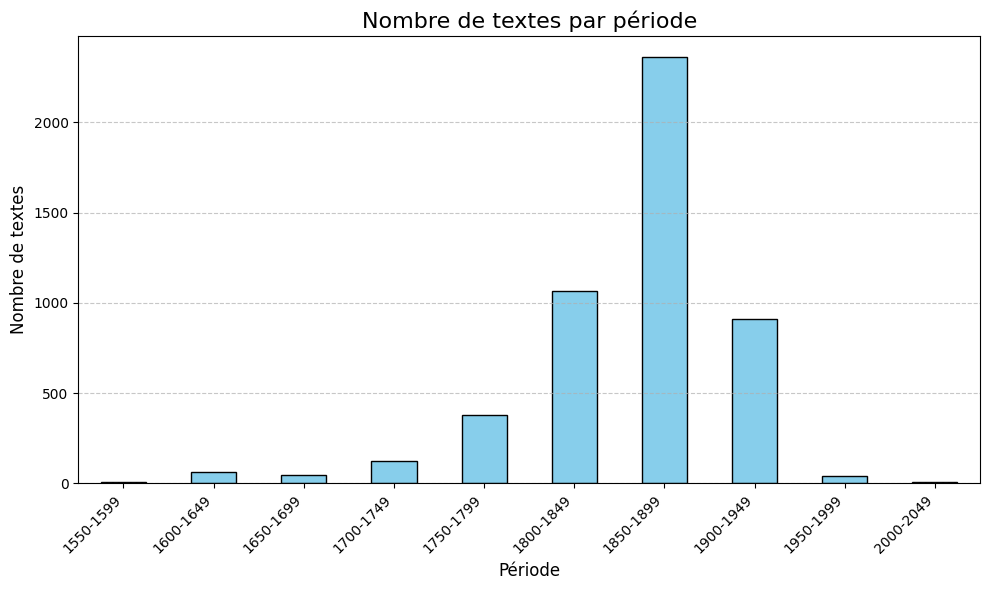

In [9]:
def create_period_label(example, period_length=50):
     """
          Crée une étiquette de période basée sur l'année de publication.
     """
     try:
          year = int(example['date'])
          start_year = (year // period_length) * period_length
          end_year = start_year + period_length - 1

          return {"period": f"{start_year}-{end_year}"}
     except (ValueError, TypeError):
          return {"period": None}
     
dataset_with_labels = cleaned_ds.map(create_period_label)

df = pd.DataFrame(dataset_with_labels)

grouped_texts = df.groupby('period')['text'].apply(list)

period_counts = grouped_texts.apply(len).sort_index()

plt.figure(figsize=(10, 6))
period_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Nombre de textes par période', fontsize=16)
plt.xlabel('Période', fontsize=12)
plt.ylabel('Nombre de textes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

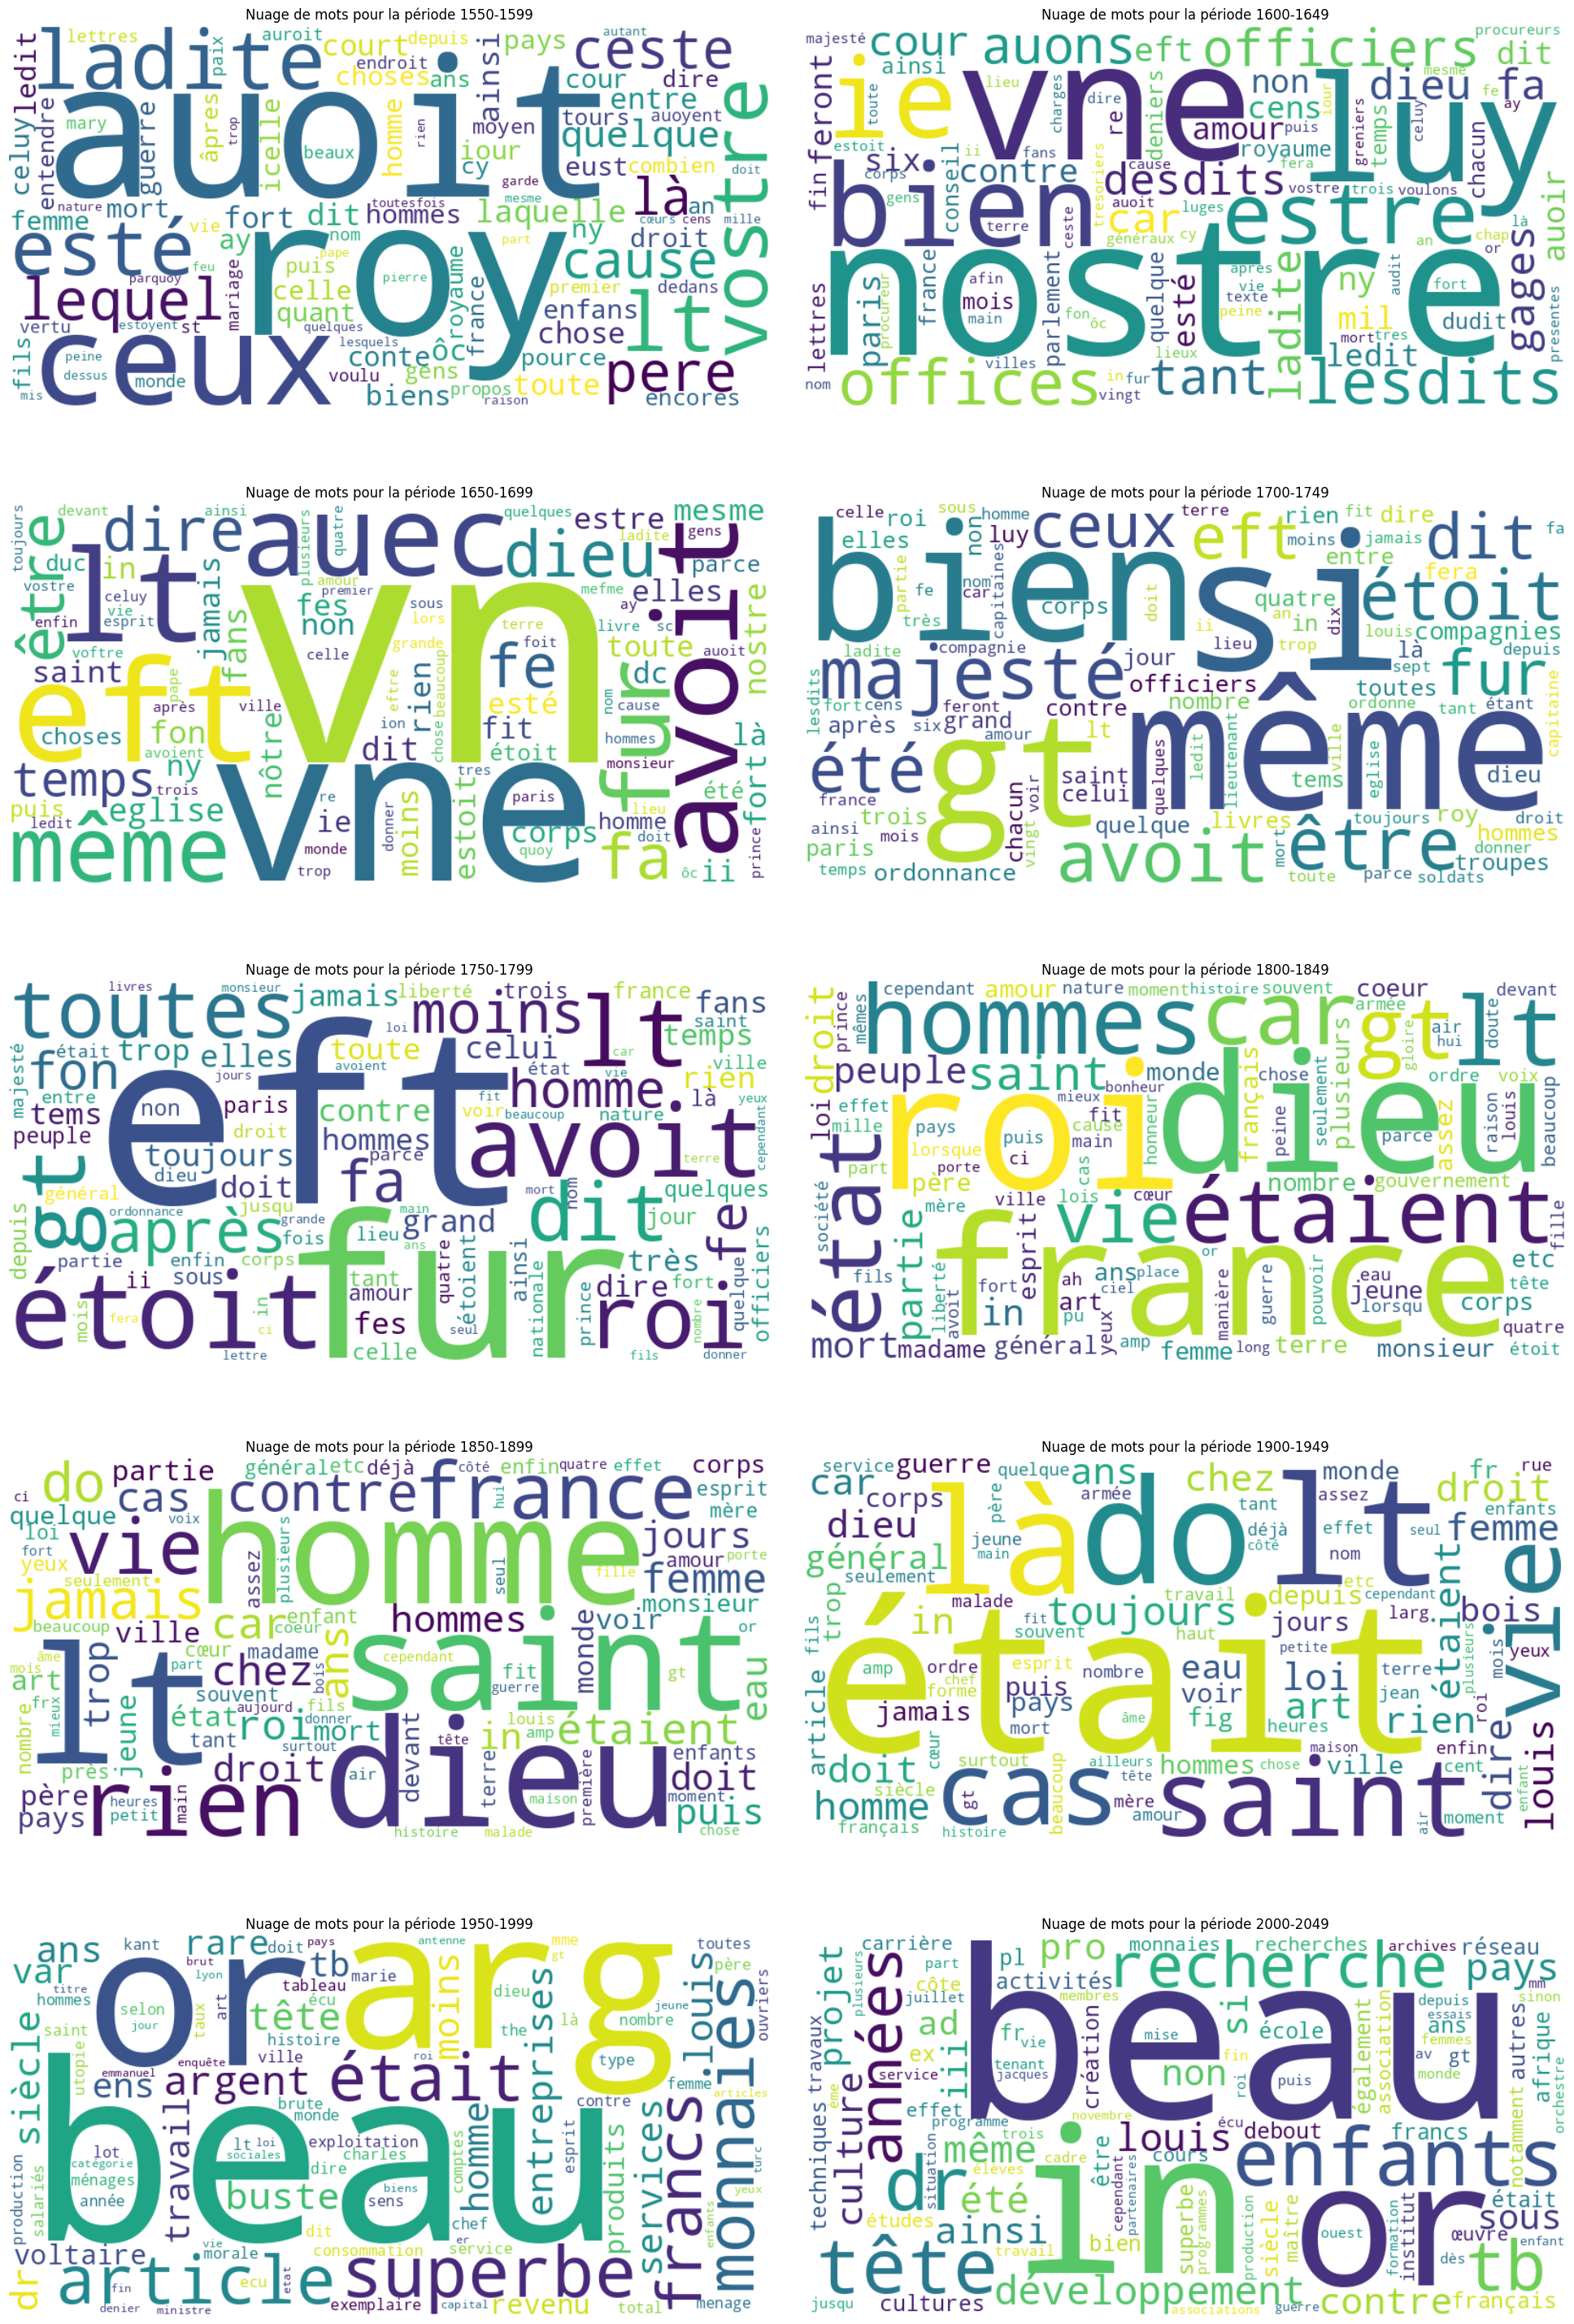

In [10]:
import os
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# --- Vos paramètres (inchangés) ---
max_features_tfidf = 5000
min_df_tfidf = 3         # Ignorer les mots trop rares
max_df_tfidf = 0.85      # Ignorer les mots trop fréquents
top_n_words = 100

# S'assurer que le répertoire existe
output_dir = "wordclouds_by_period"
os.makedirs(output_dir, exist_ok=True)

tfidf_results = {}
wordcloud_files = []

# --- Début des modifications pour le subplot ---

# 1. Déterminer le nombre de périodes à afficher
num_periods = len(grouped_texts)
if num_periods == 0:
    print("Aucune donnée à afficher.")
    # Quittez si vous êtes dans un script, ou continuez si c'est dans un notebook

# 2. Définir la grille (ex: 2 colonnes)
ncols = 2
# Calculer le nombre de lignes nécessaires (arrondi au supérieur)
nrows = math.ceil(num_periods / ncols)

# 3. Créer la figure et la grille d'axes
# Ajustez figsize au besoin: (largeur totale, hauteur totale)
fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 6))

# Aplatir le tableau d'axes pour une itération simple (ex: axes[0], axes[1]...)
# S'il n'y a qu'un seul plot, le mettre dans une liste pour que la boucle fonctionne
if num_periods > 1:
    axes = axes.flatten()
else:
    axes = [axes] # Cas où nrows=1 et ncols=1

# --- Fin des modifications ---


# Calculer le TF-IDF et générer les nuages pour chaque période
# Utiliser enumerate pour obtenir un index 'i' pour les axes
for i, (period, texts) in enumerate(grouped_texts.items()):
    
    # Sélectionner l'axe courant
    ax = axes[i]

    if not texts:
        print(f"Pas de textes pour la période {period}, subplot désactivé.")
        ax.axis('off') # Cacher l'axe s'il est vide
        continue

    try:
        tfidf_vectorizer_period = TfidfVectorizer(
            max_features=max_features_tfidf,
            min_df=min_df_tfidf,
            max_df=max_df_tfidf,
            stop_words=None # Assurez-vous d'avoir pré-traité vos stop words
        )
        tfidf_matrix = tfidf_vectorizer_period.fit_transform(texts)
        feature_names = tfidf_vectorizer_period.get_feature_names_out()
        sum_tfidf = tfidf_matrix.sum(axis=0)
        tfidf_scores = [(feature_names[col], sum_tfidf[0, col]) for col in range(sum_tfidf.shape[1])]
        tfidf_scores.sort(key=lambda x: x[1], reverse=True)
        top_words_scores = dict(tfidf_scores[:top_n_words])
        tfidf_results[period] = top_words_scores

        if not top_words_scores:
             print(f"Aucun mot pertinent trouvé pour la période {period} après TF-IDF.")
             ax.axis('off') # Cacher l'axe s'il est vide
             continue

        # Générer le nuage de mots
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_scores)

        # --- Modifications du plotting ---
        # 4. Afficher le nuage sur l'axe (subplot) spécifique
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f"Nuage de mots pour la période {period}")
        # --- Fin des modifications du plotting ---

        # (La sauvegarde de fichier reste inchangée si vous la décommentez)
        # filename = os.path.join(output_dir, f"wordcloud_{period}.png")
        # wordcloud.to_file(filename)
        # wordcloud_files.append(filename)

    except ValueError as e:
         print(f"Erreur lors du traitement de la période {period}: {e}")
         ax.axis('off') # Cacher l'axe en cas d'erreur
    except Exception as e:
        print(f"Erreur inattendue pour la période {period}: {e}")
        ax.axis('off') # Cacher l'axe en cas d'erreur

# --- Début des ajouts post-boucle ---

# 5. Cacher les axes (subplots) non utilisés
# Si vous avez 5 périodes et une grille 3x2 (6 plots), le dernier plot sera vide.
for j in range(num_periods, nrows * ncols):
    axes[j].axis('off')

# 6. Ajuster la mise en page pour éviter les superpositions
plt.tight_layout(pad=3.0)

# 7. Afficher la figure complète
plt.show()

# print("\n--- Analyse terminée ---")
# print(f"{len(wordcloud_files)} nuages de mots ont été générés dans le dossier '{output_dir}'.")

# # Afficher les noms des fichiers générés pour que l'utilisateur sache ce qui est disponible
# print("Fichiers générés :")
# for fname in wordcloud_files:
#     print(f"- {fname}")

# # Optionnel: Afficher un exemple de mots/scores TF-IDF pour une période
# # (Choisir une période existante dans tfidf_results.keys())
# example_period = list(tfidf_results.keys())[0] if tfidf_results else None
# if example_period:
#     print(f"\nExemple des mots les plus pertinents (TF-IDF) pour {example_period}:")
#     # Afficher les 10 premiers mots pour l'exemple
#     print(list(tfidf_results[example_period].items())[:10])

In [11]:
# Convertir le dataset en DataFrame pandas pour le split et la stratification
df_labeled = dataset_with_labels.to_pandas()

# Filtrer les périodes non nulles (au cas où certaines dates n'aient pas pu être converties)
df_labeled = df_labeled.dropna(subset=['period'])

# Vérifier la distribution par période et retirer les périodes trop rares
period_counts = df_labeled['period'].value_counts().sort_values(ascending=False)
print("Distribution des périodes (desc.):")
print(period_counts.head(20).to_string())

# Identifier les périodes avec moins de 2 exemples (ces classes posent problème pour stratify)
rare_periods = period_counts[period_counts < 2].index.tolist()
if rare_periods:
    print(f"Found {len(rare_periods)} period(s) with <2 samples. They will be removed for a stratified split.")
    # Option: on retire ces périodes du DataFrame pour permettre split stratifié
    df_labeled = df_labeled[~df_labeled['period'].isin(rare_periods)].reset_index(drop=True)

# Vérifier qu'il reste des données après filtrage
if df_labeled.empty:
    raise ValueError("No data left after removing rare period classes. Adjust your preprocessing or choose stratify=None.")

# Maintenant effectuer le train_test_split avec stratification sûre
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_labeled['text'],
    df_labeled['period'],
    test_size=0.2,       # 20% pour le test
    random_state=42,     # Pour la reproductibilité
    stratify=df_labeled['period'] # Pour garder la même distribution de périodes
)

print(f"Taille de l'ensemble d'entraînement : {len(train_texts)} textes.")
print(f"Taille de l'ensemble de test : {len(test_texts)} textes.")

Distribution des périodes (desc.):
period
1850-1899    2361
1800-1849    1066
1900-1949     910
1750-1799     381
1700-1749     122
1600-1649      62
1650-1699      44
1950-1999      43
2000-2049       6
1550-1599       5
Taille de l'ensemble d'entraînement : 4000 textes.
Taille de l'ensemble de test : 1000 textes.


In [12]:
# --- Vectorisation TF-IDF ---
N_FEATURES_TFIDF = 5000
MIN_DF_TFIDF = 3
MAX_DF_TFIDF = 0.85

print(f"Vectorisation TF-IDF (max_features={N_FEATURES_TFIDF})...")

# Initialiser le vectoriseur TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=N_FEATURES_TFIDF,
    ngram_range=(1, 1),  # Utiliser des unigrammes et bigrammes
    min_df=MIN_DF_TFIDF,
    max_df=MAX_DF_TFIDF
)

# Adapter (fit) le vectoriseur sur les données d'entraînement et transformer les deux ensembles
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

print(f"Dimensions de la matrice TF-IDF d'entraînement : {X_train_tfidf.shape}")
print(f"Dimensions de la matrice TF-IDF de test : {X_test_tfidf.shape}")
print("Vectorisation TF-IDF terminée.")

Vectorisation TF-IDF (max_features=5000)...
Dimensions de la matrice TF-IDF d'entraînement : (4000, 5000)
Dimensions de la matrice TF-IDF de test : (1000, 5000)
Vectorisation TF-IDF terminée.


In [13]:
# Fonction d'entraînement (version simple sans suivi de la perte)
def train_sgd_classifier(X_train, y_train, X_test, y_test, method_name=""):
    """
    Entraîne un classifieur SGD (SVM linéaire) et affiche les métriques de base.
    """
    print(f"\\n==================================================")
    print(f"Entraînement du modèle SGD (SVM) sur {method_name}")
    print(f"==================================================\\n")

    # Initialiser le classifieur
    # 'log' = Régression Logistique. 'hinge' = SVM linéaire (par défaut)
    # 'modified_huber' est robuste aux outliers et fournit des probabilités.
    classifier = SGDClassifier(loss='modified_huber', random_state=42, max_iter=1000, tol=1e-3, n_jobs=-1)

    # Entraîner le modèle
    classifier.fit(X_train, y_train)

    # Évaluation
    y_pred = classifier.predict(X_test)
    print("📄 Rapport de classification détaillé :")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    return classifier

In [14]:
# Entraîner et évaluer avec TF-IDF (méthode simple)
model_tfidf_sgd = train_sgd_classifier(
    X_train_tfidf, train_labels,
    X_test_tfidf, test_labels,
    "TF-IDF (simple)"
)

\n==================================================
Entraînement du modèle SGD (SVM) sur TF-IDF (simple)
==================================================\n
📄 Rapport de classification détaillé :
              precision    recall  f1-score   support

   1550-1599       0.00      0.00      0.00         1
   1600-1649       0.56      0.77      0.65        13
   1650-1699       0.00      0.00      0.00         9
   1700-1749       0.71      0.50      0.59        24
   1750-1799       0.75      0.75      0.75        76
   1800-1849       0.74      0.69      0.71       213
   1850-1899       0.72      0.80      0.76       472
   1900-1949       0.61      0.54      0.57       182
   1950-1999       0.80      0.44      0.57         9
   2000-2049       0.00      0.00      0.00         1

    accuracy                           0.71      1000
   macro avg       0.49      0.45      0.46      1000
weighted avg       0.70      0.71      0.70      1000



In [15]:
import random

def sample_text_by_segment(text, n_words=100):
    """
    Échantillonne N mots du début, du milieu et de la fin du texte,
    plus N mots aléatoires pour capturer le style global.
    Total = 4 * n_words.
    """
    tokens = text.split()
    if len(tokens) <= 4 * n_words:
        return text

    # Début, milieu, fin
    start_tokens = tokens[:n_words]
    middle_start = max(0, (len(tokens) // 2) - (n_words // 2))
    middle_tokens = tokens[middle_start : middle_start + n_words]
    end_tokens = tokens[-n_words:]

    # Indices déjà utilisés
    used_indices = set(range(n_words)) | \
                   set(range(len(tokens) - n_words, len(tokens))) | \
                   set(range(middle_start, middle_start + n_words))

    # Indices restants
    remaining_indices = [i for i in range(len(tokens)) if i not in used_indices]
    
    if len(remaining_indices) < n_words:
        random_tokens = [tokens[i] for i in remaining_indices]
    else:
        random_tokens = [tokens[i] for i in sorted(random.sample(remaining_indices, n_words))]

    # Combiner tous les échantillons
    combined_tokens = start_tokens + middle_tokens + end_tokens + random_tokens
    
    return " ".join(combined_tokens)

In [16]:
# Charger un modèle CamemBERT léger, spécialisé dans la création d'embeddings
embedding_model = SentenceTransformer('dangvantuan/sentence-camembert-base')

In [17]:
# Fonction pour créer les embeddings par lots (pour optimiser l'usage de la RAM)
def create_embeddings_batch(texts, model, batch_size=64):
    """
    Crée les embeddings pour une liste de textes en utilisant le modèle fourni,
    en traitant les textes par lots.
    """
    all_embeddings = []
    
    # Traiter par lots
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        # Créer les embeddings pour le lot
        batch_embeddings = model.encode(batch_texts, show_progress_bar=False, convert_to_numpy=True)
        all_embeddings.append(batch_embeddings)
        
        # Nettoyage mémoire (optionnel mais peut aider sur les grosses boucles)
        # gc.collect() 

    # Concaténer les résultats des lots
    return np.vstack(all_embeddings)

In [19]:
import math
from sklearn.metrics import log_loss

def train_sgd_with_loss_tracking(X_train, X_test, y_train, y_test, method_name="", n_epochs=50):
    """
    Entraîne un classifieur SGD (loss='log' - Régression Logistique)
    en utilisant partial_fit pour suivre la perte (loss) à chaque époque.
    """
    print(f"\\n==================================================")
    print(f"Entraînement avec suivi de la perte ({method_name})")
    print(f"==================================================\\n")

    # Utiliser 'log_loss' pour la régression logistique, ce qui permet d'utiliser predict_proba et log_loss
    classifier = SGDClassifier(loss='log_loss', random_state=42, max_iter=1, tol=None, n_jobs=-1, warm_start=True)
    
    train_loss_history = []
    test_loss_history = []

    # --- CORRECTION 1 : Obtenir la liste complète de TOUS les labels ---
    # On combine les labels du train et du test pour être sûr de n'en oublier aucun.
    all_classes = np.unique(np.concatenate((y_train, y_test)))

    print(f"Début de l'entraînement pour {n_epochs} époques...")
    for epoch in range(n_epochs):
        classifier.partial_fit(X_train, y_train, classes=all_classes)
        
        y_train_pred_proba = classifier.predict_proba(X_train)
        y_test_pred_proba = classifier.predict_proba(X_test)
        
        # --- CORRECTION 2 : Passer `labels=all_classes` à log_loss ---
        train_loss = log_loss(y_train, y_train_pred_proba, labels=all_classes)
        test_loss = log_loss(y_test, y_test_pred_proba, labels=all_classes)
        
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        
        print(f"Époque {epoch+1}/{n_epochs} - Perte entraînement: {train_loss:.4f} - Perte test: {test_loss:.4f}")

    # Visualisation de la fonction de perte
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label="Perte d'entraînement (Train Loss)")
    plt.plot(test_loss_history, label="Perte de validation (Test Loss)")
    plt.title(f"Évolution de la fonction de perte ({method_name})")
    plt.xlabel("Époques")
    plt.ylabel("Log Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Évaluation finale sur l'ensemble de test
    print("\\n------ ÉVALUATION FINALE ------")
    y_pred = classifier.predict(X_test)
    
    print("📄 Rapport de classification détaillé :")
    print(classification_report(y_test, y_pred, zero_division=0)) # Ajout de zero_division pour éviter les warnings
    
    return classifier

In [20]:
print("Échantillonnage des textes pour les embeddings...")
N_WORDS_EMBEDDING = 400 # 100 * 4 segments

# Appliquer l'échantillonnage
train_texts_sampled = [sample_text_by_segment(text, n_words=100) for text in train_texts]
test_texts_sampled = [sample_text_by_segment(text, n_words=100) for text in test_texts]

print(f"Texte original (exemple) :\\n{train_texts.iloc[0][:500]}...")
print(f"\\nTexte échantillonné (exemple) :\\n{train_texts_sampled[0][:500]}...")
print(f"\\nLongueur moyenne texte original : {np.mean([len(t.split()) for t in train_texts]):.0f} mots")
print(f"Longueur moyenne texte échantillonné : {np.mean([len(t.split()) for t in train_texts_sampled]):.0f} mots")

Échantillonnage des textes pour les embeddings...
Texte original (exemple) :\nmémoire sdr dilution samg éther sulferïque soufré moyen préventif cura f choléra docteur roux paris imprimerie bailly divry plage sorëonnej mémoire dilution sang éther sulfurique soufré moyen préventif curatif do choléra r ii roux lorsque entrepris recherches conservation matières animales gt seul but arriver pratique embaumements découverte nouveaux antiseptiques tenais toute chose approfondir phénomènes fermentation putride puiser nouveaux enseignements étude cadavre mine féconde été suffisamm...
\nTexte échantillonné (exemple) :\nmémoire sdr dilution samg éther sulferïque soufré moyen préventif cura f choléra docteur roux paris imprimerie bailly divry plage sorëonnej mémoire dilution sang éther sulfurique soufré moyen préventif curatif do choléra r ii roux lorsque entrepris recherches conservation matières animales gt seul but arriver pratique embaumements découverte nouveaux antiseptiques tenais toute cho

In [21]:
# --- Création des Embeddings ---
BATCH_SIZE = 128
N_TRAIN = len(train_texts_sampled)
N_TEST = len(test_texts_sampled)

print(f"Création des embeddings pour {N_TRAIN} textes d'entraînement...")
X_train_embedding = create_embeddings_batch(train_texts_sampled, embedding_model, batch_size=BATCH_SIZE)

print(f"Création des embeddings pour {N_TEST} textes de test...")
X_test_embedding = create_embeddings_batch(test_texts_sampled, embedding_model, batch_size=BATCH_SIZE)

print(f"\\nDimensions de la matrice d'Embeddings (entraînement) : {X_train_embedding.shape}")
print(f"Dimensions de la matrice d'Embeddings (test) : {X_test_embedding.shape}")

# Nettoyer la mémoire (le modèle d'embedding n'est plus nécessaire)
del embedding_model
del train_texts_sampled
del test_texts_sampled
gc.collect()

Création des embeddings pour 4000 textes d'entraînement...
Création des embeddings pour 1000 textes de test...
\nDimensions de la matrice d'Embeddings (entraînement) : (4000, 768)
Dimensions de la matrice d'Embeddings (test) : (1000, 768)


3697

\n==================================================
Entraînement avec suivi de la perte (TF-IDF)
==================================================\n
Début de l'entraînement pour 50 époques...
Époque 1/50 - Perte entraînement: 0.5986 - Perte test: 0.7902
Époque 2/50 - Perte entraînement: 0.5790 - Perte test: 0.7754
Époque 3/50 - Perte entraînement: 0.5723 - Perte test: 0.7676
Époque 2/50 - Perte entraînement: 0.5790 - Perte test: 0.7754
Époque 3/50 - Perte entraînement: 0.5723 - Perte test: 0.7676
Époque 4/50 - Perte entraînement: 0.5687 - Perte test: 0.7629
Époque 5/50 - Perte entraînement: 0.5664 - Perte test: 0.7598
Époque 4/50 - Perte entraînement: 0.5687 - Perte test: 0.7629
Époque 5/50 - Perte entraînement: 0.5664 - Perte test: 0.7598
Époque 6/50 - Perte entraînement: 0.5649 - Perte test: 0.7576
Époque 7/50 - Perte entraînement: 0.5637 - Perte test: 0.7560
Époque 6/50 - Perte entraînement: 0.5649 - Perte test: 0.7576
Époque 7/50 - Perte entraînement: 0.5637 - Perte test: 0.7560


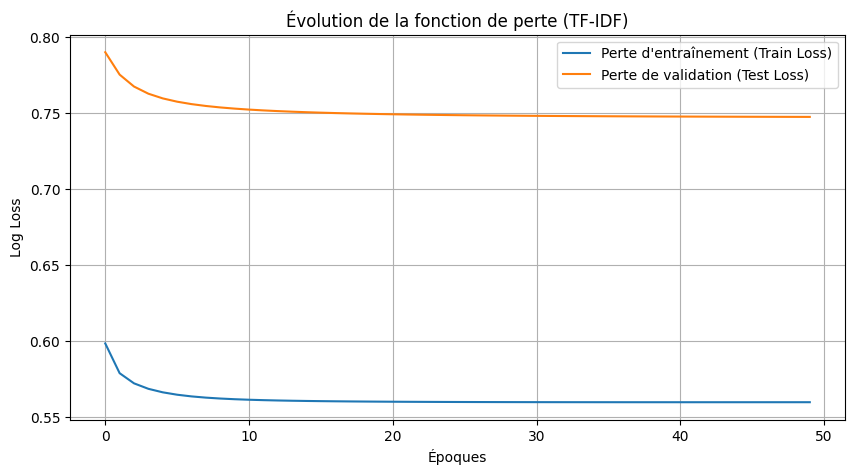

\n------ ÉVALUATION FINALE ------
📄 Rapport de classification détaillé :
              precision    recall  f1-score   support

   1550-1599       0.00      0.00      0.00         1
   1600-1649       0.60      0.92      0.73        13
   1650-1699       0.00      0.00      0.00         9
   1700-1749       0.69      0.38      0.49        24
   1750-1799       0.74      0.75      0.75        76
   1800-1849       0.80      0.64      0.71       213
   1850-1899       0.69      0.89      0.78       472
   1900-1949       0.65      0.37      0.47       182
   1950-1999       1.00      0.11      0.20         9
   2000-2049       0.00      0.00      0.00         1

    accuracy                           0.70      1000
   macro avg       0.52      0.41      0.41      1000
weighted avg       0.70      0.70      0.68      1000



In [22]:
# Entraîner et évaluer avec TF-IDF et suivi de la perte
model_tfidf_sgd_loss = train_sgd_with_loss_tracking(
    X_train_tfidf, X_test_tfidf,
    train_labels, test_labels,
    "TF-IDF",
    n_epochs=50 # Utiliser 50 époques comme pour les embeddings pour comparer
)

\n==================================================
Entraînement avec suivi de la perte (Embeddings (CamemBERT))
==================================================\n
Début de l'entraînement pour 50 époques...
Époque 1/50 - Perte entraînement: 4.0103 - Perte test: 4.3804
Époque 2/50 - Perte entraînement: 1.7525 - Perte test: 2.0926
Époque 3/50 - Perte entraînement: 1.2791 - Perte test: 1.5853
Époque 4/50 - Perte entraînement: 1.0691 - Perte test: 1.3529
Époque 5/50 - Perte entraînement: 0.9635 - Perte test: 1.2339
Époque 3/50 - Perte entraînement: 1.2791 - Perte test: 1.5853
Époque 4/50 - Perte entraînement: 1.0691 - Perte test: 1.3529
Époque 5/50 - Perte entraînement: 0.9635 - Perte test: 1.2339
Époque 6/50 - Perte entraînement: 0.9024 - Perte test: 1.1635
Époque 7/50 - Perte entraînement: 0.8633 - Perte test: 1.1175
Époque 8/50 - Perte entraînement: 0.8362 - Perte test: 1.0850
Époque 6/50 - Perte entraînement: 0.9024 - Perte test: 1.1635
Époque 7/50 - Perte entraînement: 0.8633 - Per

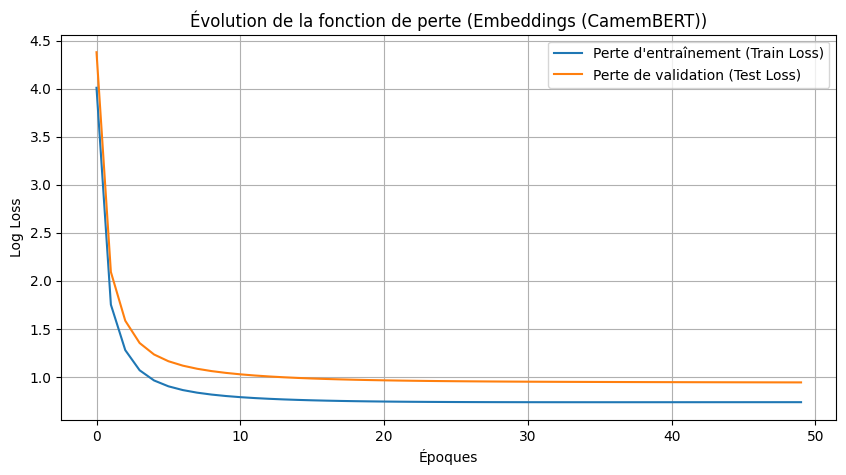

\n------ ÉVALUATION FINALE ------
📄 Rapport de classification détaillé :
              precision    recall  f1-score   support

   1550-1599       0.00      0.00      0.00         1
   1600-1649       1.00      0.54      0.70        13
   1650-1699       0.17      0.11      0.13         9
   1700-1749       0.82      0.38      0.51        24
   1750-1799       0.67      0.62      0.64        76
   1800-1849       0.54      0.54      0.54       213
   1850-1899       0.65      0.70      0.67       472
   1900-1949       0.50      0.51      0.51       182
   1950-1999       1.00      0.22      0.36         9
   2000-2049       0.00      0.00      0.00         1

    accuracy                           0.60      1000
   macro avg       0.53      0.36      0.41      1000
weighted avg       0.61      0.60      0.60      1000



In [23]:
# Entraîner et évaluer avec Embeddings et suivi de la perte
model_embedding_sgd_loss = train_sgd_with_loss_tracking(
    X_train_embedding, X_test_embedding,
    train_labels, test_labels,
    "Embeddings (CamemBERT)",
    n_epochs=50
)

In [37]:
def predict_random_text(data_source_df, vectorizer, model_tfidf, model_embedding):
    """
    Prend un texte aléatoire depuis le DataFrame source (df_labeled),
    le nettoie (si nécessaire, mais il l'est déjà), le vectorise (TF-IDF),
    crée son embedding (après échantillonnage), et affiche les prédictions
    des deux modèles.
    """
    
    # Récupérer un échantillon aléatoire
    random_sample_df = data_source_df.sample(1)
    
    # Extraire le texte et le vrai label
    # .iloc[0] pour obtenir les valeurs de la première ligne
    text_to_predict = random_sample_df['text'].iloc[0]
    true_label = random_sample_df['period'].iloc[0]

    print(f"Texte : {text_to_predict[:250]}")
    print(f"Période réelle : {true_label}")

    # --- Prédiction TF-IDF ---
    text_tfidf = vectorizer.transform([text_to_predict])
    prediction_tfidf = model_tfidf.predict(text_tfidf)[0]
    print(f"TF-IDF : {prediction_tfidf}")

    # --- Prédiction Embeddings ---
    text_sampled_emb = sample_text_by_segment(text_to_predict, n_words=100)
    try:
        embedding_model
    except NameError:
        print("Rechargement du modèle d'embedding pour la prédiction...")
        embedding_model = SentenceTransformer('dangvantuan/sentence-camembert-base')
    
    text_embedding = embedding_model.encode([text_sampled_emb], show_progress_bar=False)
    
    prediction_embedding = model_embedding.predict(text_embedding)[0]
    print(f"Embeddings : {prediction_embedding}s")

In [38]:
# --- Lancer le test ---
# Utilisez df_labeled qui contient les données prétraitées
predict_random_text(df_labeled, tfidf_vectorizer, model_tfidf_sgd_loss, model_embedding_sgd_loss)

Texte : seconp tirage tr ks gmenté tire soixante dix exemplaires vingt seulement vendus notices bibliographiques famille pidot seules partie tome ii do iii partie vhutoirt livre france paris imprimé pare thdnot rne racine ext h ii ijustoiiu gt u jvhe fhaxce 
Période réelle : 1850-1899
TF-IDF : 1850-1899
Rechargement du modèle d'embedding pour la prédiction...
Embeddings : 1850-1899s
Embeddings : 1850-1899s


In [28]:
def test_multiple_predictions(data_source_df, vectorizer, model_tfidf, model_embedding, num_tests=20):
    """
    Exécute N tests de prédiction aléatoire et compare les résultats.
    """
    print(f"--- Lancement de {num_tests} essais de prédiction ---")
    
    correct_tfidf = 0
    correct_embedding = 0
    
    # Recharger le modèle d'embedding une seule fois
    try:
        embedding_model
    except NameError:
        embedding_model = SentenceTransformer('dangvantuan/sentence-camembert-base')

    for i in range(num_tests):
        # Récupérer un échantillon
        sample_df = data_source_df.sample(1)
        text = sample_df['text'].iloc[0]
        true_label = sample_df['period'].iloc[0]

        # TF-IDF
        text_tfidf = vectorizer.transform([text])
        pred_tfidf = model_tfidf.predict(text_tfidf)[0]
        
        # Embedding
        text_sampled = sample_text_by_segment(text, n_words=100)
        text_emb = embedding_model.encode([text_sampled], show_progress_bar=False)
        pred_emb = model_embedding.predict(text_emb)[0]

        if pred_tfidf == true_label:
            correct_tfidf += 1
        if pred_emb == true_label:
            correct_embedding += 1
            
        print(f"Essai {i+1}/{num_tests} | Réel : {true_label} | TF-IDF : {pred_tfidf} | Embeddings : {pred_emb}")

    print("\\n--- Résultats des tests ---")
    print(f"TF-IDF Accuracy : {(correct_tfidf / num_tests) * 100:.2f}% ({correct_tfidf}/{num_tests})")
    print(f"Embeddings Accuracy : {(correct_embedding / num_tests) * 100:.2f}% ({correct_embedding}/{num_tests})")
    
    # Retourner les scores pour le graphique
    return (correct_tfidf / num_tests), (correct_embedding / num_tests)

--- Lancement de 20 essais de prédiction ---
Essai 1/20 | Réel : 1850-1899 | TF-IDF : 1850-1899 | Embeddings : 1850-1899
Essai 1/20 | Réel : 1850-1899 | TF-IDF : 1850-1899 | Embeddings : 1850-1899
Essai 2/20 | Réel : 1900-1949 | TF-IDF : 1850-1899 | Embeddings : 1850-1899
Essai 2/20 | Réel : 1900-1949 | TF-IDF : 1850-1899 | Embeddings : 1850-1899
Essai 3/20 | Réel : 1850-1899 | TF-IDF : 1850-1899 | Embeddings : 1850-1899
Essai 3/20 | Réel : 1850-1899 | TF-IDF : 1850-1899 | Embeddings : 1850-1899
Essai 4/20 | Réel : 1850-1899 | TF-IDF : 1850-1899 | Embeddings : 1850-1899
Essai 4/20 | Réel : 1850-1899 | TF-IDF : 1850-1899 | Embeddings : 1850-1899
Essai 5/20 | Réel : 1850-1899 | TF-IDF : 1850-1899 | Embeddings : 1850-1899
Essai 6/20 | Réel : 1700-1749 | TF-IDF : 1700-1749 | Embeddings : 1700-1749
Essai 5/20 | Réel : 1850-1899 | TF-IDF : 1850-1899 | Embeddings : 1850-1899
Essai 6/20 | Réel : 1700-1749 | TF-IDF : 1700-1749 | Embeddings : 1700-1749
Essai 7/20 | Réel : 1850-1899 | TF-IDF : 18

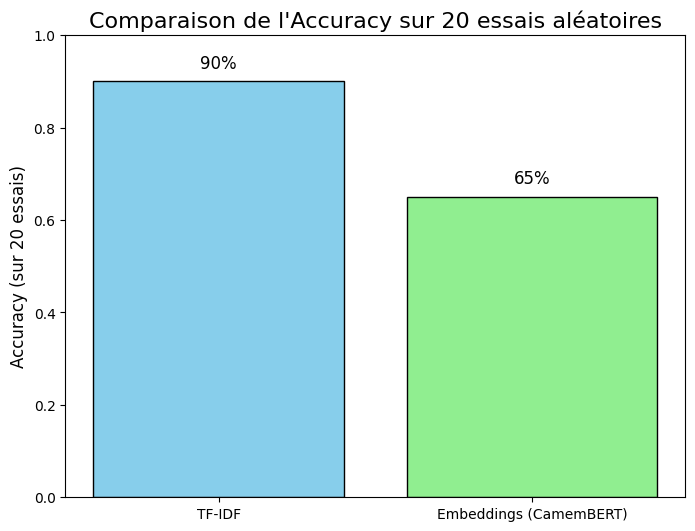

In [29]:
# Lancer 20 essais
tfidf_acc, emb_acc = test_multiple_predictions(
    df_labeled, 
    tfidf_vectorizer, 
    model_tfidf_sgd_loss, 
    model_embedding_sgd_loss, 
    num_tests=20
)

# Visualisation finale des résultats des tests
plt.figure(figsize=(8, 6))
models = ['TF-IDF', 'Embeddings (CamemBERT)']
accuracies = [tfidf_acc, emb_acc]
colors = ['skyblue', 'lightgreen']

bars = plt.bar(models, accuracies, color=colors, edgecolor='black')

plt.ylabel('Accuracy (sur 20 essais)', fontsize=12)
plt.title('Comparaison de l\'Accuracy sur 20 essais aléatoires', fontsize=16)
plt.ylim(0, 1)

# Ajouter les pourcentages sur les barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval*100:.0f}%', ha='center', va='bottom', fontsize=12)

plt.show()

Génération des prédictions sur l'ensemble de test...
Affichage des 1000 échantillons de test, triés par période réelle.


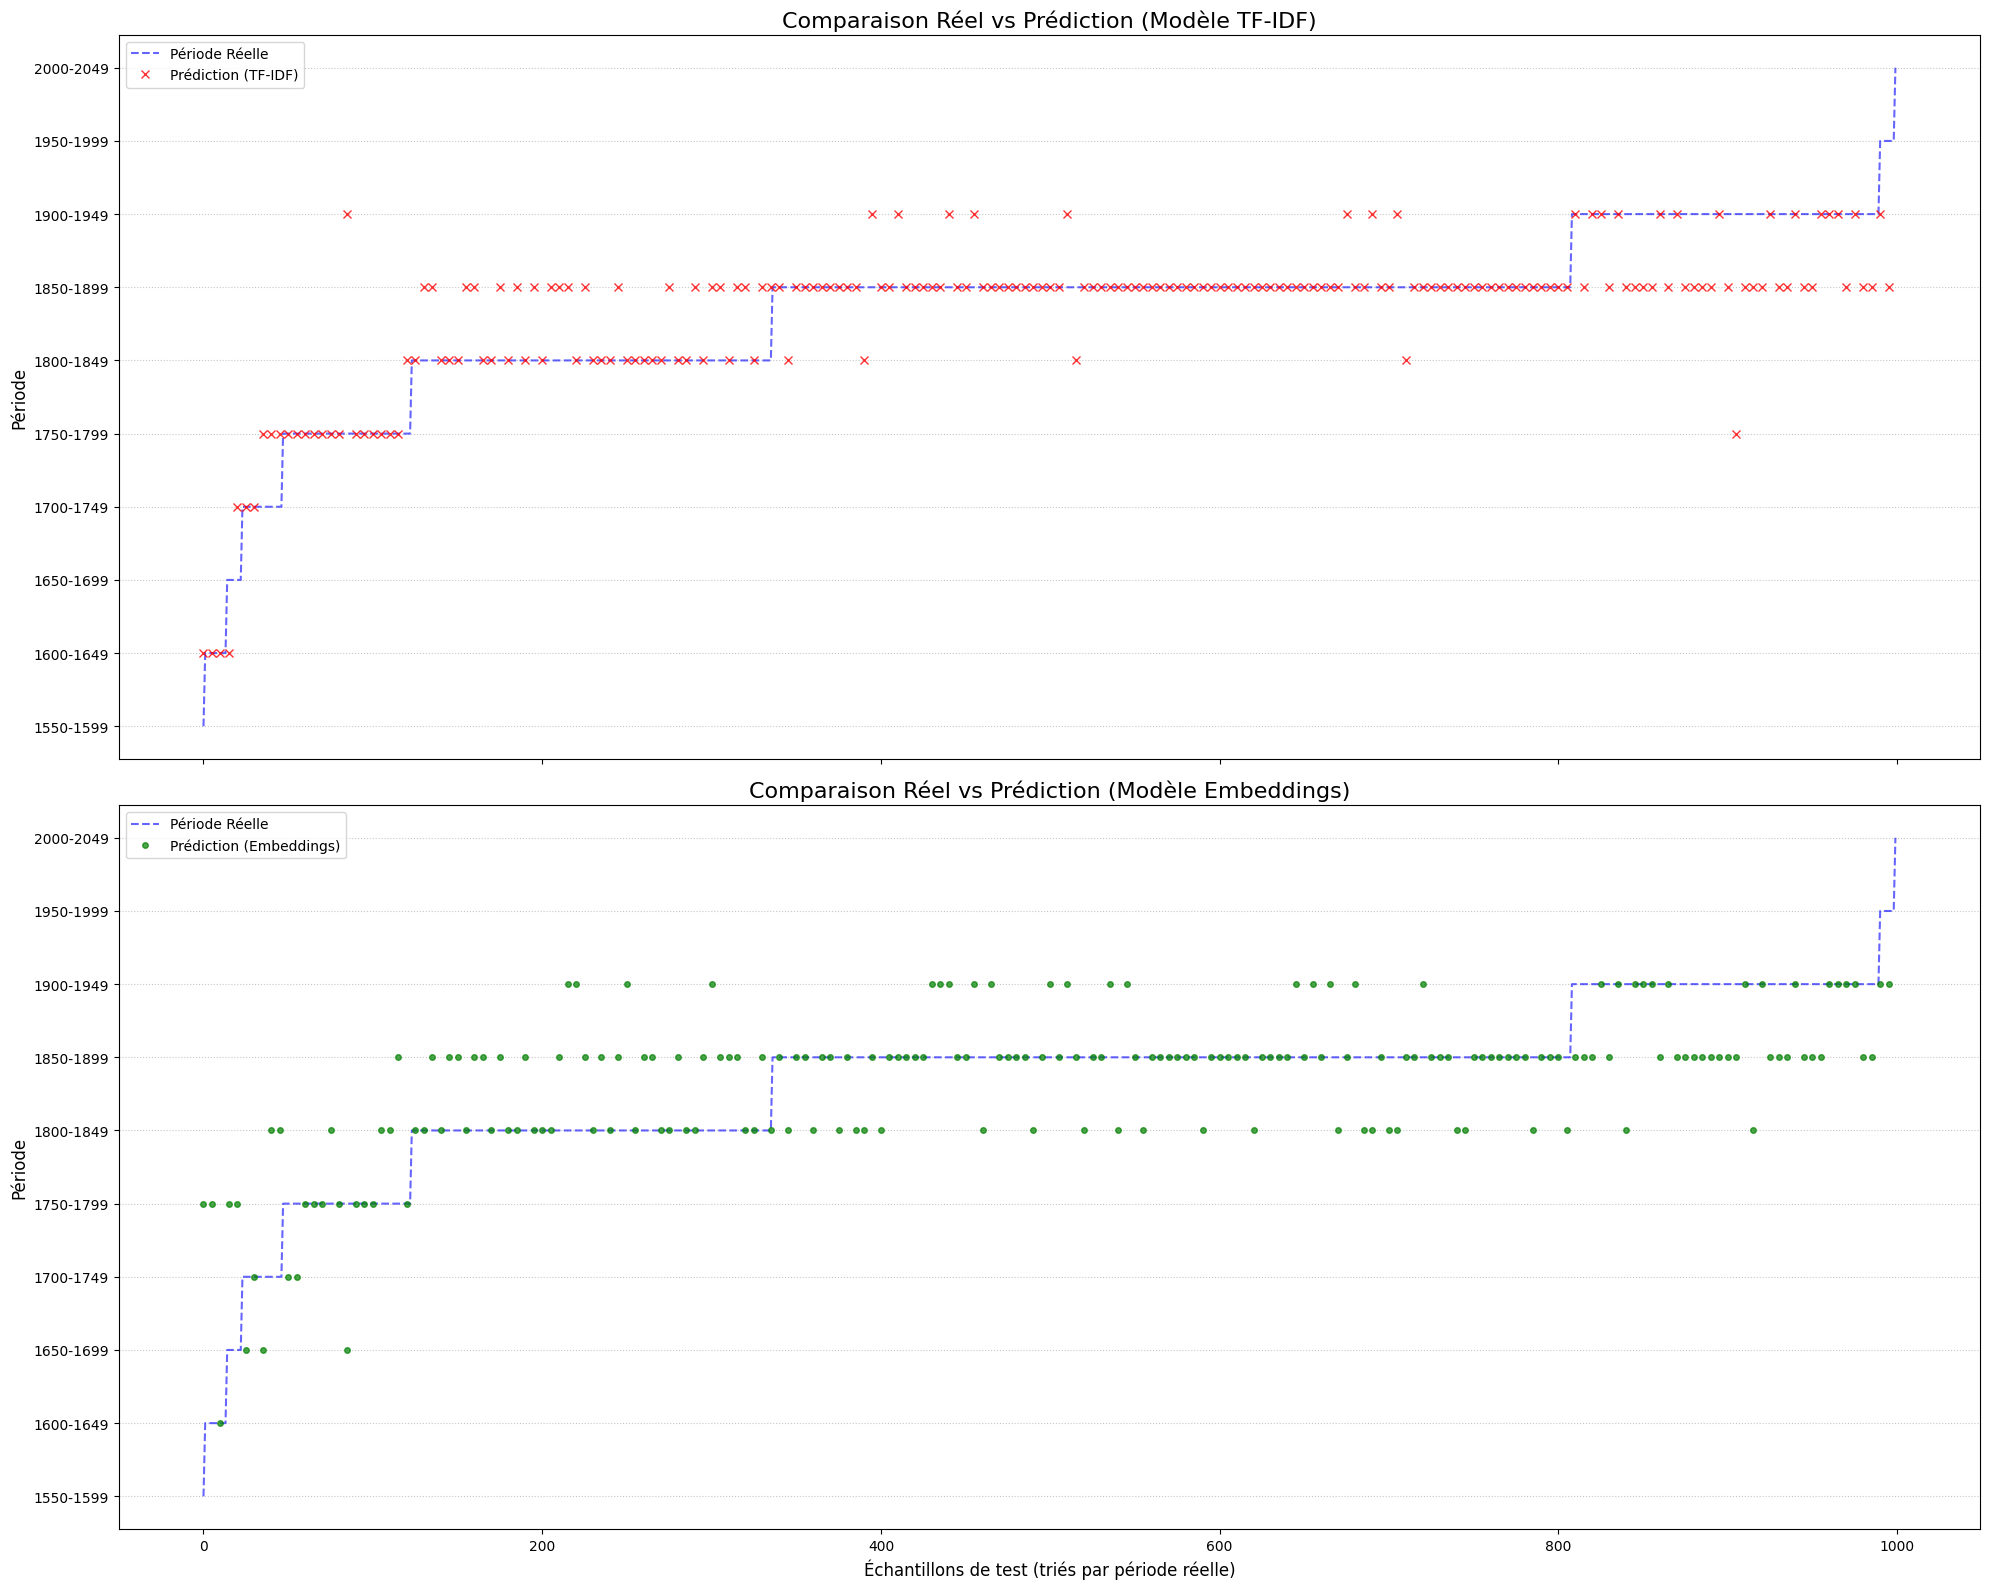

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

print("Génération des prédictions sur l'ensemble de test...")

# 1. Obtenir les prédictions pour les deux modèles
y_pred_tfidf = model_tfidf_sgd_loss.predict(X_test_tfidf)
y_pred_embeddings = model_embedding_sgd_loss.predict(X_test_embedding)

# 2. Obtenir les étiquettes réelles (test_labels est un objet Series)
y_actual = test_labels

# 3. Créer un DataFrame pour une manipulation facile
df_results = pd.DataFrame({
    'Actual': y_actual,
    'Pred_TFIDF': y_pred_tfidf,
    'Pred_Embeddings': y_pred_embeddings
})

# 4. Trier le DataFrame par la valeur réelle (chronologiquement)
# reset_index(drop=True) crée un nouvel index de 0 à N,
# qui servira d'axe X pour notre graphique.
df_sorted_results = df_results.sort_values(by='Actual').reset_index(drop=True)

print(f"Affichage des {len(df_sorted_results)} échantillons de test, triés par période réelle.")

# 5. Créer les graphiques de comparaison
# Nous créons 2 sous-graphiques (un pour chaque modèle)
fig, (ax1, ax2) = plt.subplots(
    nrows=2,         # 2 graphiques l'un en dessous de l'autre
    ncols=1,         # 1 colonne
    figsize=(20, 16), # Taille globale de la figure (largeur, hauteur)
    sharex=True,     # L'axe X est partagé
    sharey=True      # L'axe Y est partagé (mêmes périodes)
)

# --- Graphique 1 : TF-IDF ---

# Ligne de base (Réel) : Nous la traçons comme une ligne pointillée
ax1.plot(df_sorted_results.index, df_sorted_results['Actual'], 
         '--', # Style de ligne pointillé
         color='blue', 
         label='Période Réelle',
         alpha=0.6)

# Prédictions (Points) : Nous les traçons comme des 'x' rouges
# 'markevery=5' ne trace qu'un point sur 5 pour éviter un graphique surchargé
ax1.plot(df_sorted_results.index, df_sorted_results['Pred_TFIDF'], 
         'x',  # Marqueur 'x'
         color='red', 
         label='Prédiction (TF-IDF)',
         alpha=0.8,
         markevery=5) 

ax1.set_title("Comparaison Réel vs Prédiction (Modèle TF-IDF)", fontsize=16)
ax1.set_ylabel("Période", fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(axis='y', linestyle=':', alpha=0.7)


# --- Graphique 2 : Embeddings ---

# Ligne de base (Réel)
ax2.plot(df_sorted_results.index, df_sorted_results['Actual'], 
         '--', 
         color='blue', 
         label='Période Réelle',
         alpha=0.6)

# Prédictions (Points)
ax2.plot(df_sorted_results.index, df_sorted_results['Pred_Embeddings'], 
         'o',  # Marqueur 'o' (cercle)
         color='green', 
         label='Prédiction (Embeddings)',
         alpha=0.7,
         markersize=4, # Taille des marqueurs
         markevery=5)

ax2.set_title("Comparaison Réel vs Prédiction (Modèle Embeddings)", fontsize=16)
ax2.set_xlabel("Échantillons de test (triés par période réelle)", fontsize=12)
ax2.set_ylabel("Période", fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(axis='y', linestyle=':', alpha=0.7)

# Ajuster l'espacement pour éviter que les titres se chevauchent
plt.tight_layout()

# Afficher le graphique
plt.show()